In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy
import seaborn as sns
import joblib
import os

In [ ]:
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5
        self.y_true, self.y_score = [], []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
    #     x_event_pred = torch.zeros_like(batch.x_t.float())
    #     for i in range(len(batch.x_t)):
    #         x_event_pred[i] = x_hat[batch_hyper == i].mean()

    #     pred_probs = x_event_pred.detach().cpu().numpy()
    #     true_labels = batch.x_t.detach().cpu().numpy()
    #     self.y_score.extend(pred_probs)
    #     self.y_true.extend(true_labels)

    #     pred_class = (x_event_pred > 0.5).float()
    #     acc = (pred_class == batch.x_t.float()).float().mean()
    #     self.log('val_acc_hyper', acc, prog_bar=True)
    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        self.y_score.append(x_event_pred.detach().cpu())
        self.y_true.append(batch.x_t.detach().cpu())

        pred_class = (x_event_pred > 0.5).float()
        acc = (pred_class == batch.x_t.float()).float().mean()

        self.log('val_acc_hyper', acc, prog_bar=True, on_step=False, on_epoch=True)


    def on_validation_epoch_end(self):

        y_true = torch.cat(self.y_true).numpy()
        y_pred = torch.cat(self.y_score).numpy()
        y_pred_class = (y_pred > 0.5).astype(int)

        roc = roc_auc_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec  = recall_score(y_true, y_pred_class)

        self.log('val_roc_auc', roc, prog_bar=True)
        self.log('val_f1', f1)
        self.log('val_precision', prec)
        self.log('val_recall', rec)

        print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")
# Accuracy: {acc:.4f}, 
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid()
        plt.show()

        cm = confusion_matrix(y_true, y_pred_class)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # row-wise normalization

        sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

        plt.hist(y_pred[y_true == 1], bins=20, alpha=0.7, label='Signal', color='blue', density=True)
        plt.hist(y_pred[y_true == 0], bins=20, alpha=0.7, label='Background', color='red', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Signal vs Background Probabilities')
        plt.legend()
        plt.grid()
        plt.show()

        joblib.dump((y_true, y_pred), 'results/hyper_model_output.pkl')
        torch.save(self.state_dict(), 'results/hyper_model.pt')

        self.y_true.clear()
        self.y_score.clear()
        # self.y_true.clear()
        # self.y_score.clear()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.8,
    patience=10
)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc_hyper",
                "interval": "epoch",
                "strict": True,
            },
        }


In [3]:
ckpt_path = "checkpoints/hyper-best.ckpt"

model = HyPERModel.load_from_checkpoint(ckpt_path)
model.eval()
model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [4]:
print(model)


HyPERModel(
  (model): MPNNs(
    (MPNNBlock): MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=29, out_features=32, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.01, inplace=False)
        (3): Linear(in_features=32, out_features=32, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.01, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
      )
    ),
      node_model=NodeModel(
      (node_mlp_1): Sequential(
        (0): Linear(in_features=27, out_features=32, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.01, inplace=False)
        (3): Linear(in_features=32, out_features=32, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.01, inplace=False)
        (6): Linear(in_features=32, out_features=32, bias=True)
      )
      (node_mlp_2): Sequential(
        (0): Linear(in_features=79, out_features=32, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.01, inplace=False)
  

In [5]:
import os
import numpy as np
import torch
import uproot
import joblib

from torch_geometric.loader import DataLoader


In [6]:
ckpt_path = "checkpoints/hyper-best.ckpt"

model = HyPERModel.load_from_checkpoint(ckpt_path)
model.eval()
model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model loaded on:", device)


Model loaded on: cuda


In [7]:
def delta_r(eta1, phi1, eta2, phi2):
    dphi = (phi1 - phi2 + np.pi) % (2*np.pi) - np.pi
    deta = eta1 - eta2
    return np.sqrt(deta**2 + dphi**2)


def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)


In [8]:
def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data


In [9]:

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data is not None:
            data["root_event_idx"] = i
            data_list.append(data)

    return data_list


In [10]:
def predict_event_scores(model, data_list):
    loader = DataLoader(data_list, batch_size=64, shuffle=False)
    scores = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            x_hat, batch_hyper, _ = model(batch)

            x_event_pred = torch.zeros(len(batch.x_t), device=device)
            for i in range(len(batch.x_t)):
                x_event_pred[i] = x_hat[batch_hyper == i].mean()

            scores.append(x_event_pred.cpu())

    return torch.cat(scores).numpy()


In [11]:
def extract_event_physics(tree, i):
    return {
        "jets": {
            "pt":   tree["Jet.PT"][i],
            "eta":  tree["Jet.Eta"][i],
            "phi":  tree["Jet.Phi"][i],
            "mass": tree["Jet.Mass"][i],
        },
        "electrons": {
            "pt":  tree["Electron.PT"][i],
            "eta": tree["Electron.Eta"][i],
            "phi": tree["Electron.Phi"][i],
        },
        "muons": {
            "pt":  tree["Muon.PT"][i],
            "eta": tree["Muon.Eta"][i],
            "phi": tree["Muon.Phi"][i],
        },
        "met": {
            "pt":  tree["MissingET.MET"][i],
            "phi": tree["MissingET.Phi"][i],
        }
    }


In [12]:
def extract_event_physics(events, i):
    return {
        "jets": {
            "pt":   events["Jet.PT"][i],
            "eta":  events["Jet.Eta"][i],
            "phi":  events["Jet.Phi"][i],
            "mass": events["Jet.Mass"][i],
        },
        "electrons": {
            "pt":  events["Electron.PT"][i],
            "eta": events["Electron.Eta"][i],
            "phi": events["Electron.Phi"][i],
        },
        "muons": {
            "pt":  events["Muon.PT"][i],
            "eta": events["Muon.Eta"][i],
            "phi": events["Muon.Phi"][i],
        },
        "met": {
            "pt":  events["MissingET.MET"][i],
            "phi": events["MissingET.Phi"][i],
        }
    }


In [13]:
def process_file(tag, root_file, threshold=0.5, outdir="selected_events"):
    os.makedirs(outdir, exist_ok=True)

    print(f"\nProcessing {tag}")

    # Build hypergraphs
    data_list = load_data_hyper_format(root_file, label=0)
    scores = predict_event_scores(model, data_list)

    # Read ROOT arrays ONCE
    file = uproot.open(root_file)
    tree = file["Delphes"]
    events = tree.arrays(
        library="np",
        filter_name=[
            "Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass",
            "Electron.PT", "Electron.Eta", "Electron.Phi",
            "Muon.PT", "Muon.Eta", "Muon.Phi",
            "MissingET.MET", "MissingET.Phi"
        ]
    )

    n_events = len(events["Jet.PT"])

    selected_events = []

    for data_obj, score in zip(data_list, scores):
        if score > threshold:
            idx = data_obj.root_event_idx

            # Safety check (should never fail now)
            if idx >= n_events:
                continue

            evt = extract_event_physics(events, idx)
            evt["score"] = float(score)
            selected_events.append(evt)

    outfile = f"{outdir}/{tag}_selected.pkl"
    joblib.dump(selected_events, outfile)

    print(f"Selected {len(selected_events)} / {len(scores)} events")


In [17]:
data_files = {
    'signal':  '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_signal_5k.root',
    'ttH_Bkg': '/home/sandeep/Desktop/Windows files/project rootfiles/ttbarH.root',
    'ttZ_Bkg': '/home/sandeep/Desktop/Windows files/project rootfiles/ttbarZ.root',
    'ttW_Bkg': '/home/sandeep/Desktop/Windows files/project rootfiles/ttbarW.root',
    'smBkg':   '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_BKG_5k.root',
    'sm_ltth_k1_1K2_0': '/home/sandeep/Desktop/sm_ltth_k1_1K2_0.root',
    'sm_ltth_k1_0K2_1': '/home/sandeep/Desktop/sm_ltth_k1_0K2_1.root',


}


In [18]:
tree_name = "Delphes"

jet_features = [
    "Jet.PT", "Jet.Phi", "Jet.Mass", "Jet.NCharged",
    "Jet.EhadOverEem", "Jet.Eta", "Jet.BTag", "Jet.Flavor",
    "Jet.T", "Jet.DeltaEta", "Jet.DeltaPhi",
    "Jet.ChargedEnergyFraction", "Jet.NeutralEnergyFraction"
]

lepton_features = [
    "Electron.PT", "Electron.Eta", "Electron.Phi",
    "Muon.PT", "Muon.Eta", "Muon.Phi"
]

met_features = [
    "MissingET.MET", "MissingET.Phi"
]

all_features = jet_features + lepton_features + met_features

delta_r_threshold = 1.0   # must match training


In [19]:
for tag, path in data_files.items():
    process_file(tag, path, threshold=0.5)



Processing signal
Selected 4024 / 4993 events

Processing ttH_Bkg
Selected 4118 / 4957 events

Processing ttZ_Bkg
Selected 1622 / 4891 events

Processing ttW_Bkg
Selected 3283 / 4879 events

Processing smBkg
Selected 1622 / 4891 events

Processing sm_ltth_k1_1K2_0
Selected 98123 / 99982 events

Processing sm_ltth_k1_0K2_1
Selected 98006 / 99987 events


In [20]:
def process_file(tag, root_file, threshold=0.5, outdir="selected_events"):
    os.makedirs(outdir, exist_ok=True)

    data_list = load_data_hyper_format(root_file, label=0)
    scores = predict_event_scores(model, data_list)

    # Save selected events (as before)
    file = uproot.open(root_file)
    tree = file["Delphes"]
    events = tree.arrays(
        library="np",
        filter_name=[
            "Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass",
            "Electron.PT", "Electron.Eta", "Electron.Phi",
            "Muon.PT", "Muon.Eta", "Muon.Phi",
            "MissingET.MET", "MissingET.Phi"
        ]
    )

    selected_events = []
    for data_obj, score in zip(data_list, scores):
        if score > threshold:
            idx = data_obj.root_event_idx
            evt = extract_event_physics(events, idx)
            evt["score"] = float(score)
            selected_events.append(evt)

    joblib.dump(
        selected_events,
        f"{outdir}/{tag}_selected_thr{threshold:.2f}.pkl"
    )

    return scores


In [21]:
all_scores = {}

for tag, path in data_files.items():
    print(f"Running inference for {tag}")
    scores = process_file(tag, path, threshold=0.0)  # keep everything
    all_scores[tag] = scores


Running inference for signal
Running inference for ttH_Bkg
Running inference for ttZ_Bkg
Running inference for ttW_Bkg
Running inference for smBkg
Running inference for sm_ltth_k1_1K2_0
Running inference for sm_ltth_k1_0K2_1


In [22]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]


In [23]:
import pandas as pd

rows = []

for thr in thresholds:
    row = {"threshold": thr}
    for tag, scores in all_scores.items():
        eff = (scores > thr).sum() / len(scores)
        row[tag] = eff
    rows.append(row)

eff_table = pd.DataFrame(rows)
eff_table


,threshold,signal,ttH_Bkg,ttZ_Bkg,ttW_Bkg,smBkg,sm_ltth_k1_1K2_0,sm_ltth_k1_0K2_1
0,0.3,0.935710,0.939883,0.564097,0.838696,0.564097,0.997019,0.996650
1,0.4,0.876627,0.891063,0.440605,0.755688,0.440605,0.991889,0.990739
2,0.5,0.805928,0.830744,0.331630,0.672884,0.331630,0.981407,0.980187
3,0.6,0.705788,0.741376,0.234512,0.551138,0.234512,0.959883,0.958125
4,0.7,0.552574,0.595925,0.138826,0.381636,0.138826,0.905543,0.900647


In [24]:
all_scores = {}

for tag, path in data_files.items():
    print(f"Running inference for {tag}")
    scores = process_file(tag, path, threshold=0.6) 
    all_scores[tag] = scores

Running inference for signal
Running inference for ttH_Bkg
Running inference for ttZ_Bkg
Running inference for ttW_Bkg
Running inference for smBkg
Running inference for sm_ltth_k1_1K2_0
Running inference for sm_ltth_k1_0K2_1


In [25]:
FINAL_THRESHOLD = 0.6

final_counts = {}

for tag, path in data_files.items():
    print(f"\nFinal selection for {tag}")
    scores = process_file(tag, path, threshold=FINAL_THRESHOLD)
    final_counts[tag] = {
        "selected": int((scores > FINAL_THRESHOLD).sum()),
        "total": int(len(scores)),
        "efficiency": float((scores > FINAL_THRESHOLD).sum() / len(scores)),
    }



Final selection for signal

Final selection for ttH_Bkg

Final selection for ttZ_Bkg

Final selection for ttW_Bkg

Final selection for smBkg

Final selection for sm_ltth_k1_1K2_0

Final selection for sm_ltth_k1_0K2_1


In [26]:
import pandas as pd

final_table = pd.DataFrame.from_dict(final_counts, orient="index")
final_table


,selected,total,efficiency
signal,3524,4993,0.705788
ttH_Bkg,3675,4957,0.741376
ttZ_Bkg,1147,4891,0.234512
ttW_Bkg,2689,4879,0.551138
smBkg,1147,4891,0.234512
sm_ltth_k1_1K2_0,95971,99982,0.959883
sm_ltth_k1_0K2_1,95800,99987,0.958125


In [27]:
import numpy as np

def compute_ht(event):
    """Scalar HT from jets"""
    return np.sum(event["jets"]["pt"])

def compute_njets(event, pt_min=30):
    """Jet multiplicity"""
    return np.sum(event["jets"]["pt"] > pt_min)

def compute_met(event):
    return event["met"]["pt"]


In [34]:
import joblib

def load_selected(tag):
    return joblib.load(f"selected_events/{tag}_selected_thr0.60.pkl")

samples = {
    "Signal": load_selected("signal"),
    "ttH":    load_selected("ttH_Bkg"),
    "ttW":    load_selected("ttW_Bkg"),
    "ttZ":    load_selected("ttZ_Bkg"),
    "SM":     load_selected("smBkg"),
    "sm_ltth_k1_1K2_0	":load_selected('sm_ltth_k1_1K2_0'),
    "sm_ltth_k1_0K2_1	":load_selected('sm_ltth_k1_0K2_1'),

}


In [35]:
for k, v in samples.items():
    print(k, len(v))


Signal 3524
ttH 3675
ttW 2689
ttZ 1147
SM 1147
sm_ltth_k1_1K2_0	 95971
sm_ltth_k1_0K2_1	 95800


In [36]:
kinematics = {}

for name, events in samples.items():
    ht   = np.array([compute_ht(e) for e in events])
    met  = np.array([compute_met(e) for e in events])
    nj   = np.array([compute_njets(e) for e in events])

    kinematics[name] = {
        "HT": ht,
        "MET": met,
        "Njets": nj
    }


/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


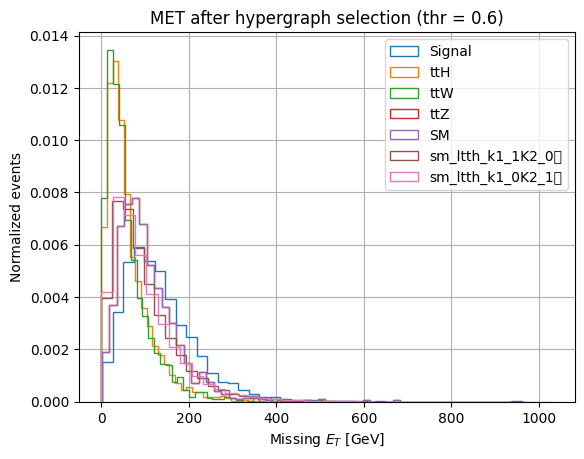

In [37]:
import matplotlib.pyplot as plt

plt.figure()
for name, data in kinematics.items():
    plt.hist(
        data["MET"],
        bins=40,
        histtype="step",
        density=True,
        label=name
    )

plt.xlabel("Missing $E_T$ [GeV]")
plt.ylabel("Normalized events")
plt.legend()
plt.grid()
plt.title("MET after hypergraph selection (thr = 0.6)")
plt.show()


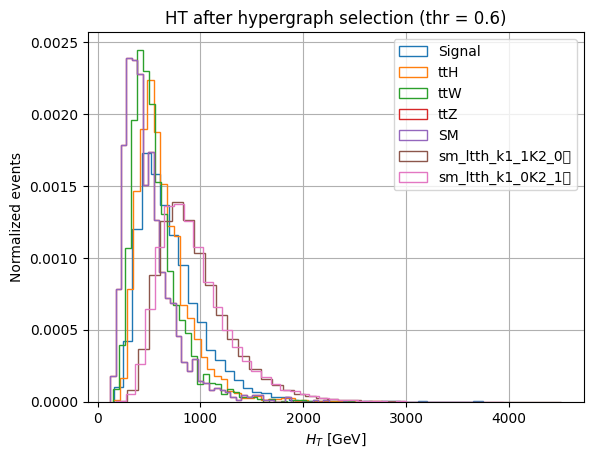

In [38]:
plt.figure()
for name, data in kinematics.items():
    plt.hist(
        data["HT"],
        bins=40,
        histtype="step",
        density=True,
        label=name
    )

plt.xlabel("$H_T$ [GeV]")
plt.ylabel("Normalized events")
plt.legend()
plt.grid()
plt.title("HT after hypergraph selection (thr = 0.6)")
plt.show()


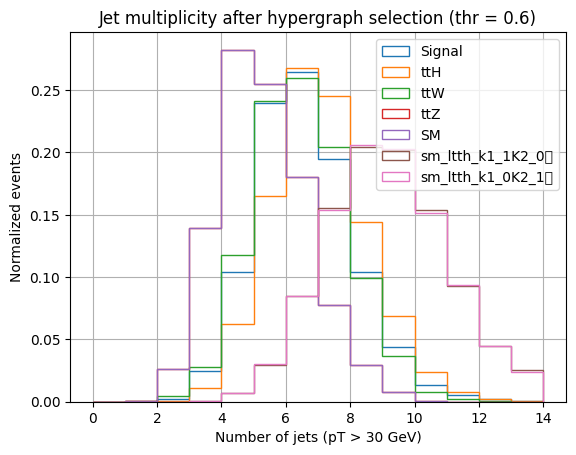

In [39]:
plt.figure()
for name, data in kinematics.items():
    plt.hist(
        data["Njets"],
        bins=np.arange(0, 15),
        histtype="step",
        density=True,
        label=name
    )

plt.xlabel("Number of jets (pT > 30 GeV)")
plt.ylabel("Normalized events")
plt.legend()
plt.grid()
plt.title("Jet multiplicity after hypergraph selection (thr = 0.6)")
plt.show()
